In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri Mar 22 21:08:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              44W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install scikit-ntk

In [ ]:
import tensorflow as tfa
import keras
from keras.layers import Dense,Flatten,MaxPool2D,Conv2D,Dropout,Activation,BatchNormalization
from keras.models import Sequential
from skntk import NeuralTangentKernel as NTK
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.signal as tf
print("all the libraries are imported")

all the libraries are imported


In [ ]:
dataset_dir=r'/content/drive/MyDrive/the dataset/dataset copy/Copy of data'
image_height=512
image_width=512
batch_size=32
seed=42
validation_split=0.1

In [ ]:
train=keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    label_mode='int',
    image_size=(image_height,image_width),
    seed=seed,
    validation_split=validation_split,
    subset='training'
)
test=keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(image_height,image_width),
    seed=seed,
    validation_split=validation_split,
    subset='validation'
)

Found 1564 files belonging to 2 classes.
Using 1408 files for training.
Found 1564 files belonging to 2 classes.
Using 156 files for validation.


In [ ]:
input_shape=(image_height,image_width,3)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
resize_rescale=keras.Sequential([
    keras.layers.Resizing(image_height,image_width),
    keras.layers.Rescaling(1./255)
])

In [ ]:
data_augmentation=keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
])

In [ ]:
with tf.device('/GPU:0'):
  def fourier(inp=None):
    if inp==None:
        pass
    elif(inp!=None):
        return tf.fft3d(inp)
  def ntk(inp=None):
    if(inp==None):
        pass
    elif(inp!=None):
        n = NTK(depth=3, bias=0.01, bias_bounds=(1e-5, 1e5))
        return n
  model=Sequential([
      resize_rescale,
      data_augmentation,

      Conv2D(64,(3,3),padding='same',input_shape=input_shape),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),

      Conv2D(64,(3,3),padding='same'),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),

      Conv2D(64,(3,3),padding='same'),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),

      Flatten(),

      Dense(64),
      Activation(fourier()),

      Dense(1),
      Activation('sigmoid')
    ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  history=model.fit(train,epochs=150,batch_size=32)

Epoch 1/150
44/44 [==============================] - 11s 73ms/step - loss: 3.6219 - accuracy: 0.6158
Epoch 2/150
44/44 [==============================] - 4s 72ms/step - loss: 0.5314 - accuracy: 0.7649
Epoch 3/150
44/44 [==============================] - 4s 72ms/step - loss: 0.5229 - accuracy: 0.7649
Epoch 4/150
44/44 [==============================] - 4s 72ms/step - loss: 0.5201 - accuracy: 0.7727
Epoch 5/150
44/44 [==============================] - 4s 72ms/step - loss: 0.5442 - accuracy: 0.7564
Epoch 6/150
44/44 [==============================] - 4s 71ms/step - loss: 0.4756 - accuracy: 0.8047
Epoch 7/150
44/44 [==============================] - 4s 71ms/step - loss: 0.4301 - accuracy: 0.8232
Epoch 8/150
44/44 [==============================] - 4s 72ms/step - loss: 0.4344 - accuracy: 0.8139
Epoch 9/150
44/44 [==============================] - 4s 71ms/step - loss: 0.4412 - accuracy: 0.8075
Epoch 10/150
44/44 [==============================] - 4s 72ms/step - loss: 0.4428 - accuracy: 0.816

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 activation (Activation)     (None, 512, 512, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                      

In [ ]:
accuracy=model.evaluate(test)
print(accuracy)

5/5 [==============================] - 4s 382ms/step - loss: 0.1285 - accuracy: 0.9423
[0.12847325205802917, 0.942307710647583]


In [ ]:
amcuracy=model.evaluate(train)
print(amcuracy)

44/44 [==============================] - 2s 44ms/step - loss: 0.1268 - accuracy: 0.9560
[0.1268196552991867, 0.9559659361839294]


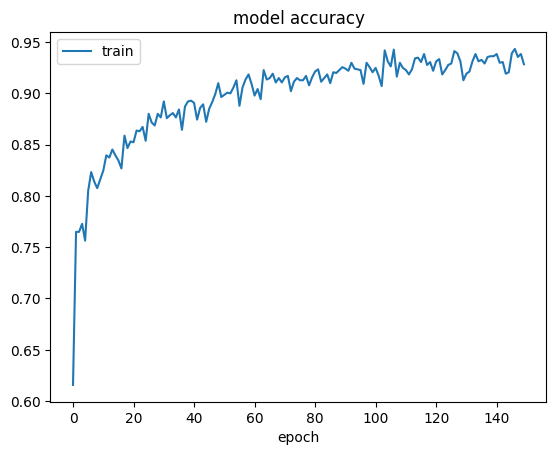

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()